In [1]:
import torch
from created_models import FeatureClassifier, CustomUNet, ConvBlock, SimpleSegNet
import random
import utils
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches

## Visualize a single image and its mask

In [2]:
train_dataset, val_dataset = utils.load_dataset()

Loading of train.jsonl: Found 845 valid images.
Loading of val.jsonl: Found 155 valid images.


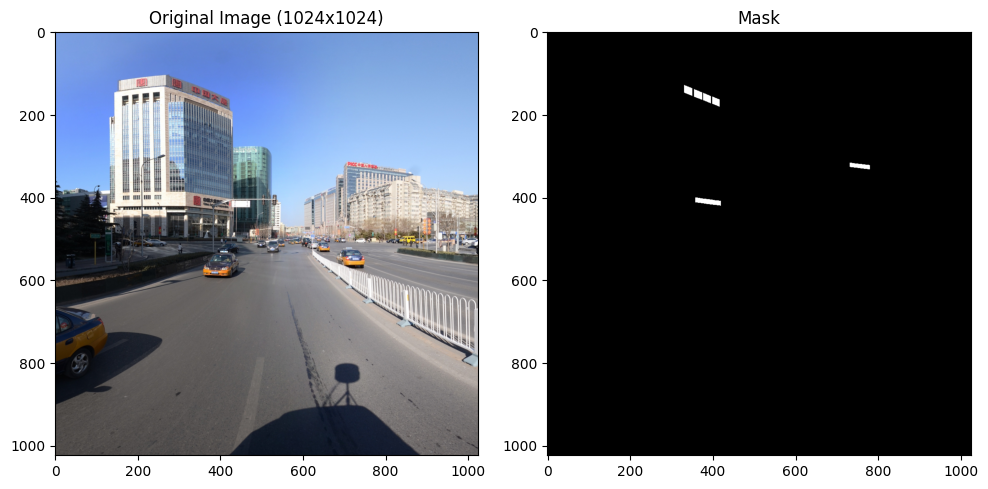

In [3]:
# Get a random item
# The function __getitem__ gives a PyTorch tensor (C, H, W)
image_random_idx = random.randint(0, len(train_dataset) - 1) 
image_tensor, mask_tensor = train_dataset[image_random_idx]

# From PyTorch (C, H, W) to NumPy/Matplotlib (H, W, C)
image_np = image_tensor.numpy().transpose(1, 2, 0)

# Mask: (1, H, W) -> (H, W). Float [0, 1]
mask_np = mask_tensor.numpy().squeeze()
# mask_np = mask_np.astype(bool) 

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Original Image
axs[0].imshow(image_np)
axs[0].set_title(f'Original Image ({image_np.shape[0]}x{image_np.shape[1]})')
axs[0].axis('on')

# Mask
axs[1].imshow(mask_np, cmap='gray')
axs[1].set_title('Mask')
axs[1].axis('on')

plt.tight_layout()
plt.show()

# SEGMENTATION: Unet
Visualize a random image of the validation dataset, its real mask for the chinese characters, its predicted mask and the overlay with the original image

In [4]:
MODEL_PATH = 'best_unet_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model load
unet_model=torch.load(MODEL_PATH, map_location=device, weights_only=False)

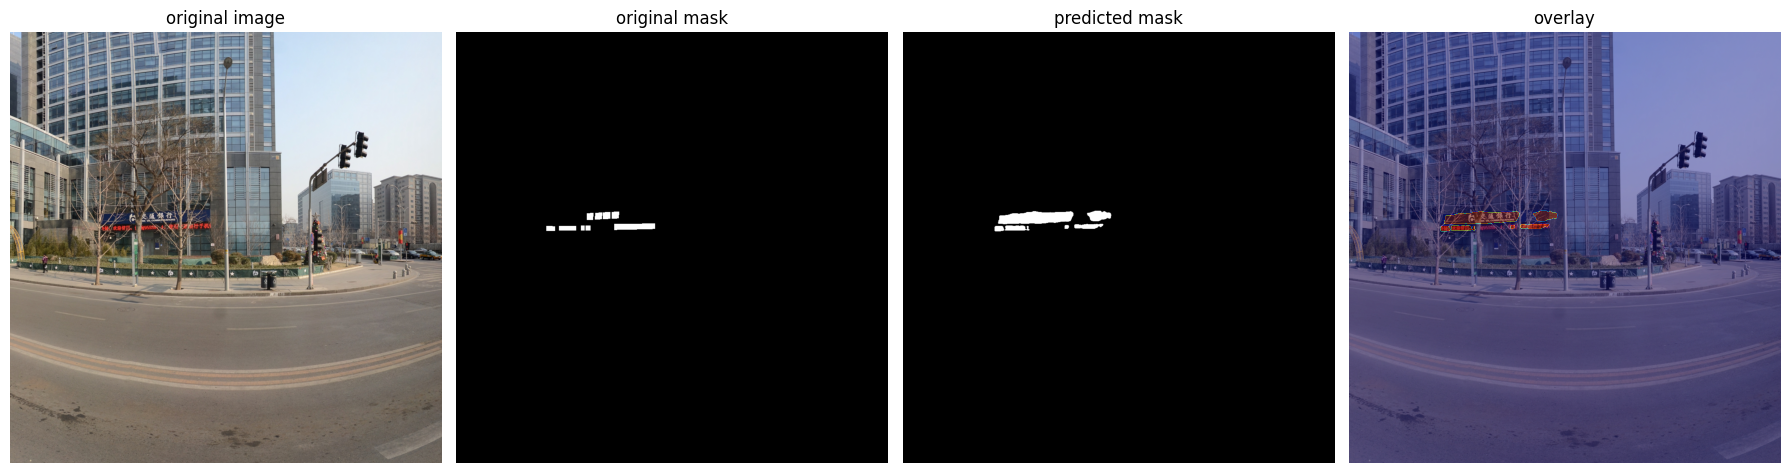

In [5]:
# Pick a random index from the validation set
ind = random.randint(0, len(val_dataset) - 1)

# Extract an item from the dataset (returns tensors: C, H, W)
img_tensor, gt_tensor = val_dataset[ind] 

# Move tensor to device (GPU/CPU) for prediction
# PyTorch expects a batch, so we add a batch dimension: (1, C, H, W)
img_batch = img_tensor.unsqueeze(0).to(device)

# Model Prediction (Manual Forward Pass)
unet_model.eval() # Evaluation mode (disables dropout, etc.)
with torch.no_grad():
    pred_tensor = unet_model(img_batch) 

# Convert tensors to NumPy for Matplotlib visualization
# Original image: (C, H, W) -> (H, W, C)
img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)

# Ground Truth: (1, H, W) -> (H, W) float in [0, 1]
gt_vis = gt_tensor.cpu().numpy().squeeze() 

# Prediction
pred_vis = pred_tensor.cpu().numpy().squeeze() 

# Plot
plt.figure(figsize=(18, 5))

# Subplot 1: Original Image
plt.subplot(1, 4, 1)
plt.title("original image")
plt.axis('off')
plt.imshow(img_np) # Already normalized [0, 1]

# Subplot 2: Ground Truth Mask
plt.subplot(1, 4, 2)
plt.title("original mask")
plt.axis('off')
plt.imshow(gt_vis, cmap='gray', vmin=0, vmax=1)

# Subplot 3: Predicted Mask (Soft Prediction)
plt.subplot(1, 4, 3)
plt.title("predicted mask")
plt.axis('off')
plt.imshow(pred_vis, cmap='gray', vmin=0, vmax=1)

# Subplot 4: Overlay (Image + Predicted Mask)
plt.subplot(1, 4, 4)
plt.title("overlay")
plt.axis('off')
plt.imshow(img_np)
# Overlay prediction with a colormap and transparency
plt.imshow(pred_vis, cmap='jet', alpha=0.4, vmin=0, vmax=1)

plt.savefig("unet_ex.png")
plt.tight_layout()
plt.show()

# SEGMENTATION: SegNet
Visualize a random image of the validation dataset, its real mask for the chinese characters, its predicted mask and the overlay with the original image

In [6]:
MODEL_PATH = 'best_segnet_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model load
segnet_model = torch.load(MODEL_PATH, map_location=device, weights_only=False)

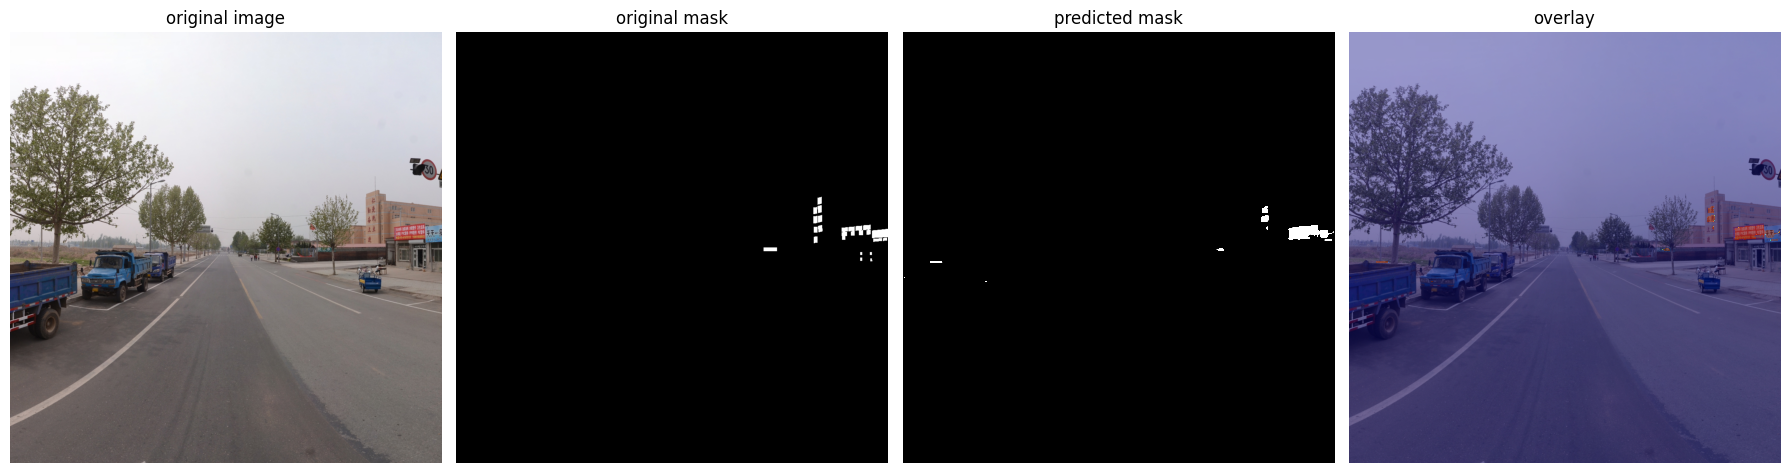

In [7]:
# Pick a random index from the validation set
ind = random.randint(0, len(val_dataset) - 1)

# Extract an item from the dataset (returns tensors: C, H, W)
img_tensor, gt_tensor = val_dataset[ind] 

# Move tensor to device (GPU/CPU) for prediction
# PyTorch expects a batch, so we add a batch dimension: (1, C, H, W)
img_batch = img_tensor.unsqueeze(0).to(device)

# Model Prediction (Manual Forward Pass)
segnet_model.eval() # Evaluation mode (disables dropout, etc.)
with torch.no_grad():
    pred_tensor = segnet_model(img_batch) 

# Convert tensors to NumPy for Matplotlib visualization
# Original image: (C, H, W) -> (H, W, C)
img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)

# Ground Truth: (1, H, W) -> (H, W) float in [0, 1]
gt_vis = gt_tensor.cpu().numpy().squeeze() 

# Prediction
pred_vis = pred_tensor.cpu().numpy().squeeze() 

# Plot
plt.figure(figsize=(18, 5))

# Subplot 1: Original Image
plt.subplot(1, 4, 1)
plt.title("original image")
plt.axis('off')
plt.imshow(img_np) # Already normalized [0, 1]

# Subplot 2: Ground Truth Mask
plt.subplot(1, 4, 2)
plt.title("original mask")
plt.axis('off')
plt.imshow(gt_vis, cmap='gray', vmin=0, vmax=1)

# Subplot 3: Predicted Mask (Soft Prediction)
plt.subplot(1, 4, 3)
plt.title("predicted mask")
plt.axis('off')
plt.imshow(pred_vis, cmap='gray', vmin=0, vmax=1)

# Subplot 4: Overlay (Image + Predicted Mask)
plt.subplot(1, 4, 4)
plt.title("overlay")
plt.axis('off')
plt.imshow(img_np)
# Overlay prediction with a colormap and transparency
plt.imshow(pred_vis, cmap='jet', alpha=0.4, vmin=0, vmax=1)

plt.savefig("segnet_ex.png")
plt.tight_layout()
plt.show()

# Classification task
We use for the classification task the most common character across the training images

## Load The Model

In [8]:
MODEL_PATH = 'best_classifier_weights.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model load
classifier_model = torch.load(MODEL_PATH, map_location=device, weights_only=False)

## Visualization of one random image of the dataset

In [9]:
val_metadata, val_clf_dataset, MOST_COMMON_CHAR = utils.load_classification_dataset()

Loading of val.jsonl: Found 155 valid images.


/home/gusdebanb@GU.GU.SE/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


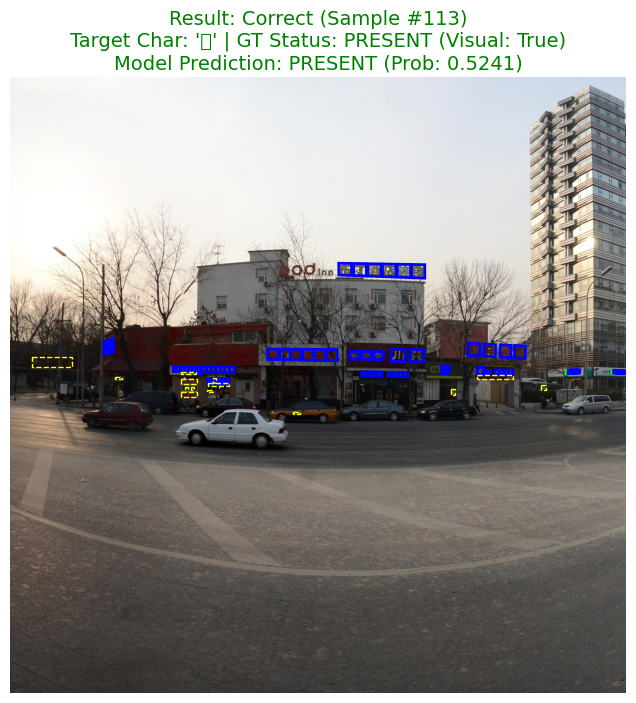

In [10]:
THRESHOLD = 0.5 # Binarization threshold for the prediction

# Set model to evaluation mode
classifier_model.eval() 

# Randomly sample an index from the validation set
ind = random.randint(0, len(val_clf_dataset) - 1)

# Get the resized image and GT label tensor for the classification model
img_tensor_resized, gt_label_tensor = val_clf_dataset[ind] 

# Get the original metadata entry for loading the original image and annotations
anno_data = val_metadata[ind]

# Prepare batch for model prediction
img_batch = img_tensor_resized.unsqueeze(0).to(device)

# MODEL PREDICTION
with torch.no_grad():
    # Predictions are LOGITS (unnormalized output, N=1, C=1)
    predictions_logits = classifier_model(img_batch)
    
    # Apply Sigmoid to get probability [0, 1]
    probability = torch.sigmoid(predictions_logits).item() 

# RESULT PREPARATION
gt_label = gt_label_tensor.item() # Ground Truth label (0.0 or 1.0)
predicted_class = 1.0 if probability >= THRESHOLD else 0.0 # Binarized prediction

# Define result text and color
is_correct = (predicted_class == gt_label)
result_text = "Correct" if is_correct else "ERROR"
color = 'green' if is_correct else 'red'

# Text for presence check
gt_text = "PRESENT" if gt_label == 1.0 else "ABSENT"
pred_text = "PRESENT" if predicted_class == 1.0 else "ABSENT"

# ANNOTATION VISUALIZATION (ON ORIGINAL IMAGE)
# Read the ORIGINAL BGR image from the file path
img_orig = cv2.imread(anno_data["file_path"], cv2.IMREAD_COLOR)
if img_orig is None:
    raise RuntimeError(f"Failed to read image: {anno_data['file_path']}")
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

# Create the plot
plt.figure(figsize=(12, 8))
ax = plt.gca()
plt.imshow(img_orig)
plt.axis('off')

# Iterate over all annotations to draw polygons
target_char_found_visual = False
for textline in anno_data.get("annotations", []):
    for instance in textline:
        # Check if polygon is valid
        if instance.get('polygon') and len(instance['polygon']) >= 3:
            polygon = instance['polygon']
            char_text = instance.get('text', '').strip()
            
            # Highlight the TARGET character polygon
            if char_text == MOST_COMMON_CHAR:
                poly_color = (0, 1, 0) # Green for target character
                target_char_found_visual = True
            elif instance.get("is_chinese", True):
                 poly_color = (0, 0, 1) # Blue for other Chinese characters
            else:
                 poly_color = (1, 0, 0) # Red for non-Chinese characters

            ax.add_patch(patches.Polygon(polygon, fill=False, color=poly_color, linewidth=2))

# Draw 'ignore' polygons
for ignore in anno_data.get('ignore', []):
    if ignore.get('polygon') and len(ignore['polygon']) >= 3:
        ax.add_patch(patches.Polygon(ignore['polygon'], fill=False, color=(1, 1, 0), linewidth=1, linestyle='--'))


# Final Title for the visualization
title = (f"Result: {result_text} (Sample #{ind})\n"
         f"Target Char: '{MOST_COMMON_CHAR}' | GT Status: {gt_text} (Visual: {target_char_found_visual})\n"
         f"Model Prediction: {pred_text} (Prob: {probability:.4f})")

plt.savefig("classifier_unet.png")
plt.title(title, fontsize=14, color=color)
plt.show()